In [20]:
#https://www.learnpytorch.io/08_pytorch_paper_replicating/#4-equation-1-split-data-into-patches-and-creating-the-class-position-and-patch-embedding

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
# from torchvision.datasets.mnist import MNIST
from keras.datasets import mnist
from torchvision.transforms import ToTensor
import torch.nn.functional as F

2025-03-16 07:38:28.334861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-16 07:38:28.343702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742110708.359598     707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742110708.363922     707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 07:38:28.379553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train = x_train.astype("float32")/255.0

x_test = x_test.astype("float32")/255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
x_train = torch.tensor(x_train).unsqueeze(1) # adding an extra dimension at 1st index, as channel dimension
x_test = torch.tensor(x_test).unsqueeze(1)

In [7]:
# train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
# test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [2]:
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """

    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        # The layer projects each patch into a vector of size hidden_size
        self.projection = nn.Conv2d(self.num_channels, self.hidden_size, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [15]:
config = {"image_size": 28, "patch_size":4, "num_channels": 1, "hidden_size": 1}

In [16]:
pembed = PatchEmbeddings(config)

In [17]:
test = pembed(x_train[0])

In [18]:
test.shape

torch.Size([1, 7, 7])

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.0.1
torchvision version: 0.15.2


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_root_path = "/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/pizza_steak_sushi"

In [5]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = 1#os.cpu_count()

In [6]:
NUM_WORKERS

1

In [7]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

    Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
    """
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [9]:
train_loader, test_loader, class_names = create_dataloaders(image_root_path+"/train", image_root_path+"/test",
                                              transform=manual_transforms, batch_size=16, num_workers=NUM_WORKERS)
# test_loader = create_dataloaders(test_set, shuffle=False, batch_size=128)

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [12]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [14]:
# Get a batch of images
image_batch, label_batch = next(iter(train_loader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

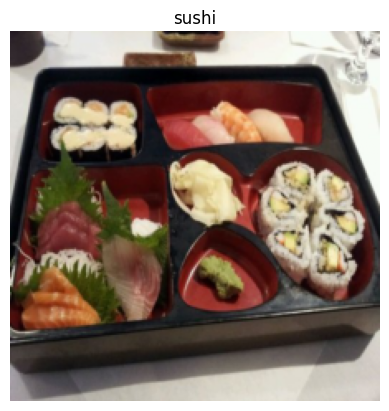

In [15]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

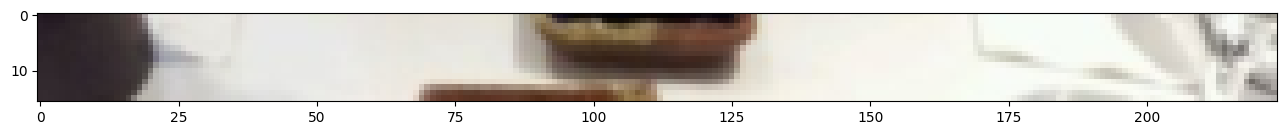

In [16]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


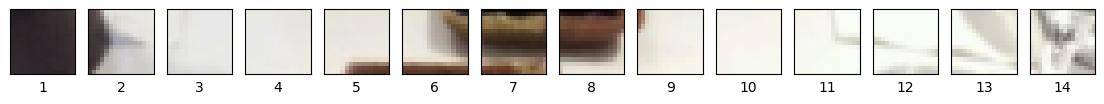

In [17]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


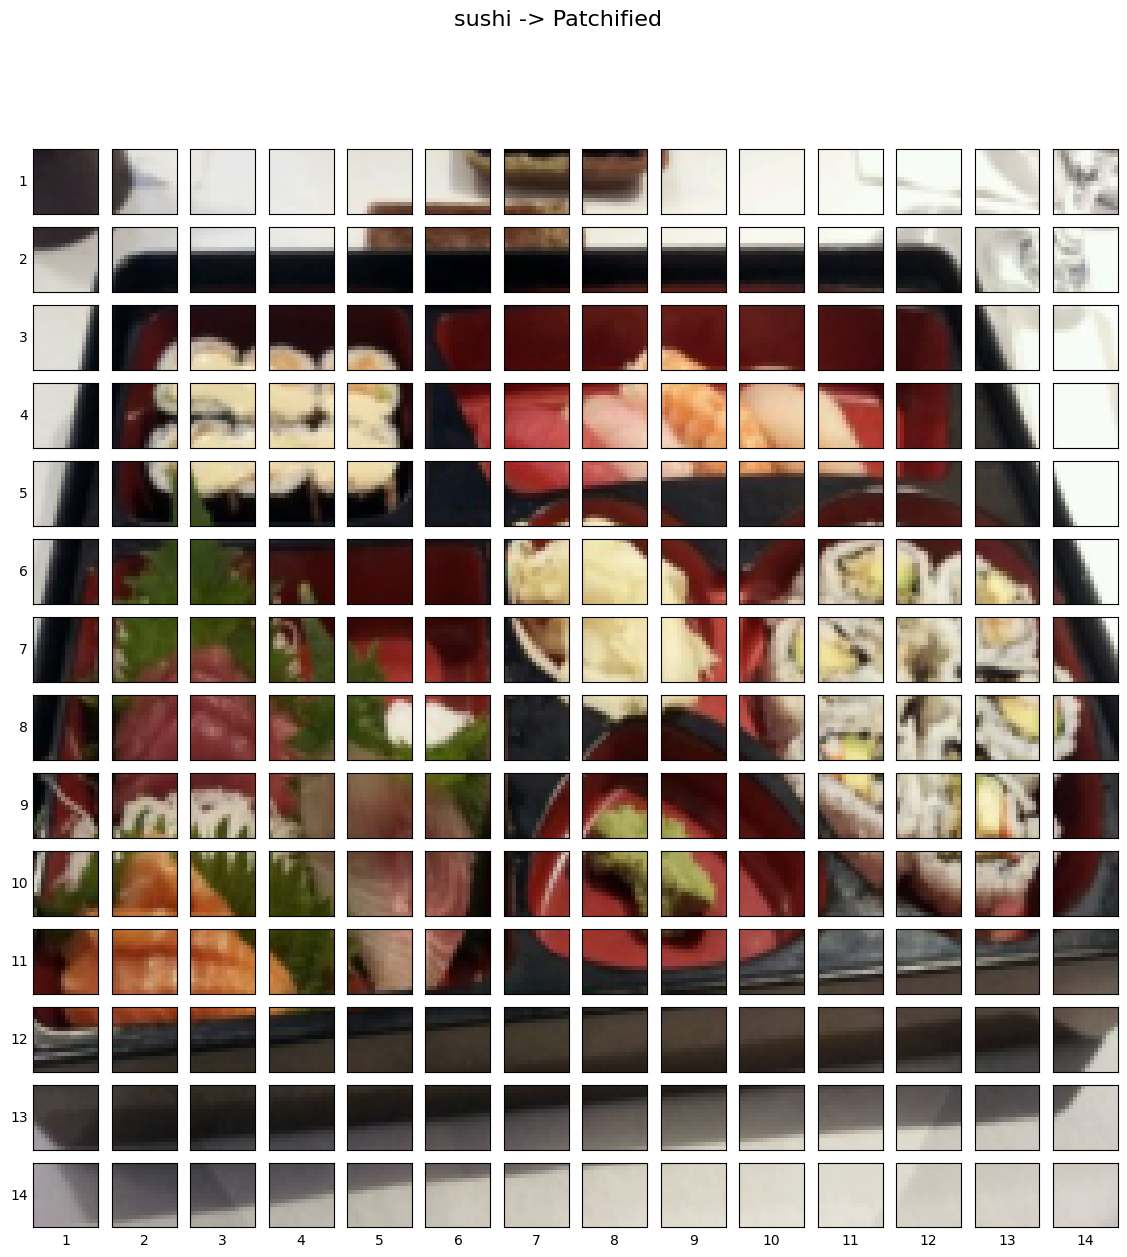

In [18]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [19]:
# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

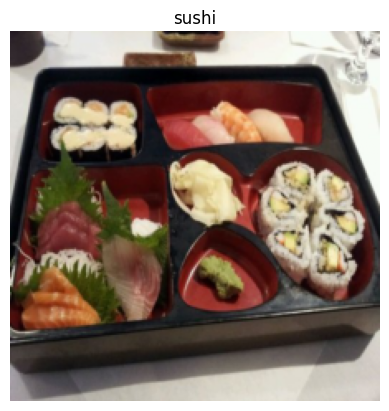

In [20]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [21]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image.shape, image_out_of_conv.shape)

torch.Size([3, 224, 224]) torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [687, 33, 462, 659, 411]


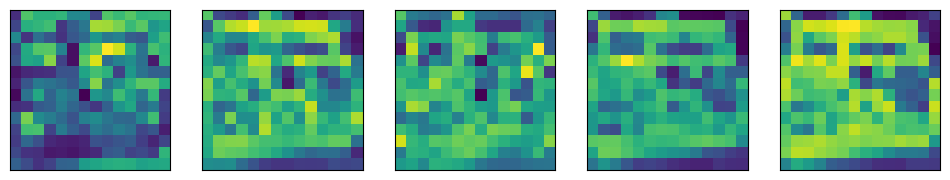

In [22]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [23]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)


In [24]:
image_out_of_conv_flattened = flatten(image_out_of_conv)

In [25]:
image_out_of_conv_flattened.shape

torch.Size([1, 768, 196])

In [26]:
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)

In [27]:
image_out_of_conv_flattened_reshaped.shape

torch.Size([1, 196, 768])

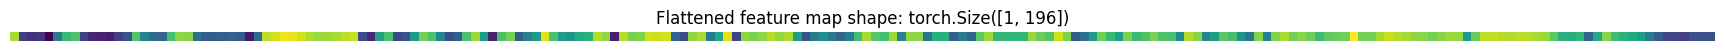

In [28]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [11]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [12]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

NameError: name 'image' is not defined

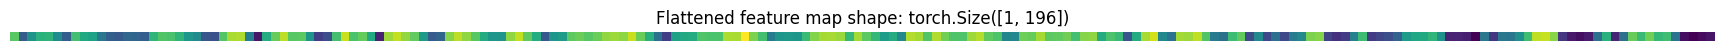

In [17]:
# Get a single flattened feature map
single_flattened_feature_map = patch_embedded_image[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [18]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [19]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1501, -0.1778, -0.1311,  ..., -0.1466, -0.4347, -0.2622],
         [-0.6476, -0.1760, -0.3839,  ..., -0.6901, -0.3449, -0.0155],
         ...,
         [-0.9731,  0.0836, -0.3483,  ..., -1.0065, -0.4120, -0.2302],
         [-0.9400,  0.0673, -0.3133,  ..., -0.9170, -0.3601, -0.2069],
         [-0.9104,  0.0617, -0.3123,  ..., -0.9220, -0.3751, -0.2120]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [20]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9298, 1.0493, 1.0824,  ..., 1.0914, 1.0626, 0.9008],
         [0.7909, 1.1816, 1.4049,  ..., 1.4830, 1.4362, 0.6403],
         ...,
         [0.8104, 1.1803, 1.2919,  ..., 1.2751, 1.3455, 0.5654],
         [0.7824, 1.1818, 1.2983,  ..., 1.2953, 1.3472, 0.5496],
         [0.7732, 1.1696, 1.3025,  ..., 1.2951, 1.3425, 0.5523]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [13]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, attn_dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(0.1),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, attn_dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, attn_dropout)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # residual connection
        x = x + self.ffwd(self.ln2(x)) # residual connection
        return x

In [14]:
n_embd = 768
dropout = 0.2
test_head = Block(768, 12, 0.1)

In [27]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0.2, # Dropout for attention projection
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=3): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[Block(n_embd=embedding_dim, n_head=num_heads, attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [28]:
model = ViT()
model = model.to("cuda")

In [29]:
epochs = 20
train_losses = []
valid_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = 1e9

In [30]:
optim = torch.optim.Adam(model.parameters(),lr=3e-3) #lr = 6e-4 / 25.
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=3e-3,steps_per_epoch=len(train_loader),epochs=epochs)

In [31]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    train_acc = 0.
    tprog = tqdm(enumerate(train_loader),total=len(train_loader))
    for i, (input_ids, labels) in tprog:
        input_ids = input_ids.to('cuda')
        labels = labels.to('cuda')
        y_pred = model(input_ids)
        loss = F.cross_entropy(y_pred,labels)
        loss.backward()
        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == labels).sum().item()/len(y_pred)
        
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_loader))
    train_accuracies.append(train_acc/len(train_loader))
    
    model.eval()
    with torch.no_grad():
        vrl = 0.
        val_acc = 0.
        vprog = tqdm(enumerate(test_loader),total=len(test_loader))
        for i, (input_ids, labels) in vprog:

            input_ids = input_ids.to('cuda')
            labels = labels.to('cuda')
            y_pred = model(input_ids)
            loss = F.cross_entropy(y_pred,labels)
            vrl += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            val_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(test_loader)
        valid_losses.append(vloss)
        val_accuracies.append(val_acc/len(test_loader))
    print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f}   train_acc: {train_accuracies[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}   valid_acc: {val_accuracies[-1]:.4f}')
        
#         if vloss < best_val_loss:
#             best_val_loss = vloss
#             print('PREDICTING!')
#             test_predictions = []
#             for input_ids in tqdm(test_batches):
#                 input_ids = input_ids.unsqueeze(0)
#                 input_ids = input_ids.to('cuda')
#                 mask_preds = model(input_ids)['mask_predictions']
#                 test_predictions.extend(list(mask_preds.detach().cpu().flatten().numpy()))
            
#             tacc = accuracy_score(test_actuals, test_predictions)
#             test_accuracies.append(tacc)
#             print(f'SINGLE MASK TOKEN PREDICTION ACCURACY: {tacc:.4f}')
#             print('saving best model...')
#             sd = model.state_dict()
#             torch.save(sd,'./mlm-baby-bert/model.pt')

train step loss: 2.5901: 100%|██████████████████| 15/15 [00:12<00:00,  1.23it/s]

  5%|██▏                                         | 1/20 [00:14<04:28, 14.15s/it]

epoch 0 | train_loss: 2.6426   train_acc: 0.3167 valid_loss: 1.7275   valid_acc: 0.2375



train step loss: 1.9469: 100%|██████████████████| 15/15 [00:21<00:00,  1.46s/it]

 10%|████▍                                       | 2/20 [00:38<06:04, 20.26s/it]

epoch 1 | train_loss: 1.3863   train_acc: 0.3458 valid_loss: 1.3359   valid_acc: 0.2375



train step loss: 1.2524: 100%|██████████████████| 15/15 [00:24<00:00,  1.66s/it]

 15%|██████▌                                     | 3/20 [01:07<06:54, 24.38s/it]

epoch 2 | train_loss: 1.3296   train_acc: 0.2625 valid_loss: 1.2558   valid_acc: 0.3125



train step loss: 0.7127: 100%|██████████████████| 15/15 [00:27<00:00,  1.85s/it]

 20%|████████▊                                   | 4/20 [01:38<07:09, 26.87s/it]

epoch 3 | train_loss: 1.1686   train_acc: 0.3750 valid_loss: 1.4523   valid_acc: 0.3125



train step loss: 0.5336: 100%|██████████████████| 15/15 [00:32<00:00,  2.15s/it]

 25%|███████████                                 | 5/20 [02:14<07:32, 30.16s/it]

epoch 4 | train_loss: 1.1202   train_acc: 0.4583 valid_loss: 1.5640   valid_acc: 0.3125



train step loss: 0.5438: 100%|██████████████████| 15/15 [00:30<00:00,  2.02s/it]

 30%|█████████████▏                              | 6/20 [02:47<07:16, 31.15s/it]

epoch 5 | train_loss: 1.1589   train_acc: 0.4375 valid_loss: 1.4589   valid_acc: 0.5000



train step loss: 0.7105: 100%|██████████████████| 15/15 [00:34<00:00,  2.28s/it]

 35%|███████████████▍                            | 7/20 [03:25<07:13, 33.34s/it]

epoch 6 | train_loss: 1.3170   train_acc: 0.4917 valid_loss: 1.8373   valid_acc: 0.2375



train step loss: 1.4924: 100%|██████████████████| 15/15 [00:34<00:00,  2.30s/it]

 40%|█████████████████▌                          | 8/20 [04:02<06:54, 34.51s/it]

epoch 7 | train_loss: 1.1621   train_acc: 0.4125 valid_loss: 1.0622   valid_acc: 0.3375



train step loss: 0.7091: 100%|██████████████████| 15/15 [00:40<00:00,  2.68s/it]

 45%|███████████████████▊                        | 9/20 [04:47<06:56, 37.90s/it]

epoch 8 | train_loss: 1.1062   train_acc: 0.4333 valid_loss: 1.2556   valid_acc: 0.4875



train step loss: 0.6356: 100%|██████████████████| 15/15 [00:44<00:00,  2.99s/it]

 50%|█████████████████████▌                     | 10/20 [05:35<06:49, 40.94s/it]

epoch 9 | train_loss: 1.1685   train_acc: 0.4750 valid_loss: 1.0406   valid_acc: 0.5068



train step loss: 1.0043: 100%|██████████████████| 15/15 [00:45<00:00,  3.02s/it]

 55%|███████████████████████▋                   | 11/20 [06:27<06:38, 44.31s/it]

epoch 10 | train_loss: 1.0350   train_acc: 0.4250 valid_loss: 1.0080   valid_acc: 0.5068



train step loss: 1.8502: 100%|██████████████████| 15/15 [00:49<00:00,  3.29s/it]

 60%|█████████████████████████▊                 | 12/20 [07:20<06:15, 46.88s/it]

epoch 11 | train_loss: 1.0004   train_acc: 0.4833 valid_loss: 1.1867   valid_acc: 0.3625



train step loss: 0.6769: 100%|██████████████████| 15/15 [00:48<00:00,  3.26s/it]

 65%|███████████████████████████▉               | 13/20 [08:15<05:46, 49.47s/it]

epoch 12 | train_loss: 1.0371   train_acc: 0.4750 valid_loss: 1.0107   valid_acc: 0.4045



train step loss: 0.8151: 100%|██████████████████| 15/15 [00:51<00:00,  3.42s/it]

 70%|██████████████████████████████             | 14/20 [09:10<05:06, 51.12s/it]

epoch 13 | train_loss: 0.9669   train_acc: 0.4958 valid_loss: 1.0015   valid_acc: 0.4523



train step loss: 0.5165: 100%|██████████████████| 15/15 [00:48<00:00,  3.22s/it]

 75%|████████████████████████████████▎          | 15/20 [10:01<04:15, 51.01s/it]

epoch 14 | train_loss: 0.8902   train_acc: 0.5917 valid_loss: 1.0592   valid_acc: 0.4659



train step loss: 0.9627: 100%|██████████████████| 15/15 [00:44<00:00,  2.98s/it]

 80%|██████████████████████████████████▍        | 16/20 [10:52<03:24, 51.06s/it]

epoch 15 | train_loss: 0.8951   train_acc: 0.6250 valid_loss: 1.0580   valid_acc: 0.4409



train step loss: 0.7304: 100%|██████████████████| 15/15 [00:47<00:00,  3.16s/it]

 85%|████████████████████████████████████▌      | 17/20 [11:44<02:33, 51.29s/it]

epoch 16 | train_loss: 0.8750   train_acc: 0.6083 valid_loss: 1.0369   valid_acc: 0.4091



train step loss: 0.0671: 100%|██████████████████| 15/15 [00:46<00:00,  3.10s/it]

 90%|██████████████████████████████████████▋    | 18/20 [12:36<01:42, 51.42s/it]

epoch 17 | train_loss: 0.8232   train_acc: 0.6083 valid_loss: 1.0368   valid_acc: 0.4466



train step loss: 0.8806: 100%|██████████████████| 15/15 [00:46<00:00,  3.13s/it]

 95%|████████████████████████████████████████▊  | 19/20 [13:29<00:52, 52.05s/it]

epoch 18 | train_loss: 0.8627   train_acc: 0.5667 valid_loss: 1.0464   valid_acc: 0.4159



train step loss: 0.1353: 100%|██████████████████| 15/15 [00:48<00:00,  3.25s/it]

100%|███████████████████████████████████████████| 20/20 [14:23<00:00, 43.18s/it]

epoch 19 | train_loss: 0.8075   train_acc: 0.6458 valid_loss: 1.0486   valid_acc: 0.4284


In [45]:
import gc
torch.cuda.empty_cache()
gc.collect()

3047